In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from shapely.geometry import Polygon, MultiPoint
import cv2

### Prepare data from ChEMBL raw source

In [ ]:
import pandas as pd

# ChEMBL 31 (https://chembl.gitbook.io/chembl-interface-documentation/downloads)
df = pd.read_csv('chembl_31_chemreps.txt', sep='\t')
df.head()

In [ ]:
# inchi type raise missing structures.
df = df.drop(columns=['standard_inchi', 'standard_inchi_key'])

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def get_molecular_weight(smi):
    try:
        _mol = Chem.MolFromSmiles(smi)
        return Descriptors.MolWt(_mol)
    except:
        print(smi)
        return 0

def check_ion(smi):
    if '.' in smi:
        return 1
    return 0

def rewrite_chembl_id(x):
    # _length = len(x)
    _numbers = int(x[6:])
    return f"CHEMBL{_numbers:07d}"

In [ ]:
df = df.sample(frac=0.1)
df['has_ion'] = df['canonical_smiles'].apply(check_ion)
df = df.loc[df['has_ion'] == 0]
df['mol_weight'] = df['canonical_smiles'].apply(get_molecular_weight)
df = df.loc[(df['mol_weight'] < 600) & (df['mol_weight'] > 10)]
df['chembl_id'] = df['chembl_id'].apply(rewrite_chembl_id)

In [ ]:
df.to_csv('chembl_31_smiles_sample.csv', index=False)

In [ ]:
df.head()

### Prepare data from `chembl_31_smiles_sample.csv`

In [ ]:
import pandas as pd

df = pd.read_csv('chembl_31_smiles_sample.csv')
df.head()

In [ ]:
# df_train = df.sample(frac=0.2)
df_train = df.loc[df['has_wedge'] == 1].sample(frac=0.5)
df_val = df.loc[~df.index.isin(df_train.index)].sample(frac=0.01)
df_test = df.loc[(~df.index.isin(df_train.index)) & (~df.index.isin(df_val.index))].sample(frac=0.02)

In [ ]:
df_train.to_csv('chembl_31_smiles_train.csv', index=False)
df_val.to_csv('chembl_31_smiles_val.csv', index=False)
df_test.to_csv('chembl_31_smiles_test.csv', index=False)

### Prepare data from predefined data of this repo

In [1]:
import pandas as pd

from targets import DBNetTargets
from chem import MolSVG

import albumentations as A

targets = DBNetTargets(shrink_ratio=0.5, thr_max=0.8)

blur = A.GaussianBlur(blur_limit=(5, 5), sigma_limit=(0.6, 0.6), always_apply=True)  # like gradient

In [ ]:
from matplotlib import pyplot as plt

# _smi = 'CN(C)CCOc1cc(NC(=O)Nc2cccc([N+](=O)[O-])c2)ccc1I'
_smi = 'O=C(OCc1ccccc1)c1sc2c([N+](=O)[O-])c(O)c(O)cc2c1Cl'
# _smi = 'c1ccc(CNC[C@@H]2C[C@@]3(c4ccccc4)CCN2C3)cc1'
# _smi = 'c1c(C(=O)O)c(OC(=O)C)ccc1'

mol_svg = MolSVG(_smi, scalingFactor=24) # 0
# mol_svg = MolSVG(_smi, multipleBondOffset=0.16, scalingFactor=24, fixedFontSize=12) # 1
# mol_svg = MolSVG(_smi, bondLineWidth=1, multipleBondOffset=0.16, scalingFactor=24, fixedFontSize=16, additionalAtomLabelPadding=0.08, gray=True, comic=True)  # 2
# mol_svg = MolSVG(_smi, bondLineWidth=1, multipleBondOffset=0.10, scalingFactor=24, fixedFontSize=13, gray=True)  # 3
x = mol_svg.image
y = targets.generate_targets(mol_svg)

fig, ax = plt.subplots(2, 3, figsize=(15, 6), sharey=True, dpi=150)
ax[0, 0].imshow(x)
# ax[0, 0].axis('off')
ax[0, 0].set_title('Image')
ax[0, 1].imshow(y['gt_shr'])
ax[0, 1].axis('off')
ax[0, 1].set_title('gt_shr')
ax[0, 2].imshow(y['gt_shr_mask'])
ax[0, 2].axis('off')
ax[0, 2].set_title('gt_shr_mask')
ax[1, 0].imshow(blur(image=y['gt_thr'])['image'])
ax[1, 0].axis('off')
ax[1, 0].set_title('gt_thr')
ax[1, 1].imshow(y['gt_thr_mask'])
ax[1, 1].axis('off')
ax[1, 1].set_title('gt_thr_mask')

In [ ]:
!tar xzf chembl_31_smiles_learning_data.csv.tar.gz

In [2]:
train = pd.read_csv('chembl_31_smiles_train.csv')
eval = pd.read_csv('chembl_31_smiles_val.csv')

df = pd.concat([train, eval])

In [11]:
from pathlib import Path
from PIL import Image

def save_image(idx):
    _id = df.iloc[idx, 0]
    _smi = df.iloc[idx, 1]
    _dir = f"{HOME_DIR}/{_id[6]}/{_id[7]}/{_id[8]}/{_id[9]}/{_id[10]}"
    if not Path(f"{_dir}/{_id}.thr_mask.png").exists():
        Path(_dir).absolute().mkdir(parents=True, exist_ok=True)

        # mol_svg = MolSVG(_smi, scalingFactor=24) # 0
        # mol_svg = MolSVG(_smi, multipleBondOffset=0.16, scalingFactor=24, fixedFontSize=12) # 1
        # mol_svg = MolSVG(_smi, bondLineWidth=1, multipleBondOffset=0.16, scalingFactor=24, fixedFontSize=16, additionalAtomLabelPadding=0.08, gray=True, comic=True)  # 2
        mol_svg = MolSVG(_smi, bondLineWidth=1, multipleBondOffset=0.10, scalingFactor=24, fixedFontSize=13, gray=True)  # 3

        # mol_svg = MolSVG(_smi) # 0
        # mol_svg = MolSVG(_smi, multipleBondOffset=0.16, scalingFactor=30, fixedFontSize=13) # 1
        # mol_svg = MolSVG(_smi, bondLineWidth=1, multipleBondOffset=0.16, fixedFontSize=14, additionalAtomLabelPadding=0.1, gray=True, comic=True)  # 2
        # mol_svg = MolSVG(_smi, bondLineWidth=1, multipleBondOffset=0.11, fixedFontSize=13, gray=True)  # 3

        x = mol_svg.image
        try:
            y = targets.generate_targets(mol_svg)
            pil_image = Image.fromarray(x)
            pil_image.save(f"{_dir}/{_id}.png")
            pil_img_shr = Image.fromarray(y['gt_shr'])
            pil_img_shr.save(f"{_dir}/{_id}.shr.png")
            pil_img_shr_mask = Image.fromarray(y['gt_shr_mask'])
            pil_img_shr_mask.save(f"{_dir}/{_id}.shr_mask.png")
            pil_img_thr = Image.fromarray(blur(image=y['gt_thr'])['image'])
            # pil_img_thr = Image.fromarray(y['gt_thr'])
            pil_img_thr.save(f"{_dir}/{_id}.thr.png")
            pil_img_thr_mask = Image.fromarray(y['gt_thr_mask'])
            pil_img_thr_mask.save(f"{_dir}/{_id}.thr_mask.png")
            return x.shape[:2]
        except ValueError:
            print(_smi)
            return (0, 0)

In [12]:
from multiprocessing import Pool

HOME_DIR = '../../Data/ChEMBL/OCR_RGB_sep_3'

_index = [_ for _ in range(len(df))]

with Pool(16) as pool:
    shapes = pool.map(save_image, _index, chunksize=8)

# 5 min; used 16 core of AMD Ryzen 5800X; 22052 smiles to image

In [13]:
import numpy as np

shapes = np.array(shapes)
shapes.mean(axis=0)

array([208.19638491, 274.49192281])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 50. ,  67.6,  85.2, 102.8, 120.4, 138. , 155.6, 173.2, 190.8,
        208.4, 226. , 243.6, 261.2, 278.8, 296.4, 314. , 331.6, 349.2,
        366.8, 384.4, 402. , 419.6, 437.2, 454.8, 472.4, 490. , 507.6,
        525.2, 542.8, 560.4, 578. , 595.6, 613.2, 630.8, 648.4, 666. ,
        683.6, 701.2, 718.8, 736.4, 754. , 771.6, 789.2, 806.8, 824.4,
        842. , 859.6, 877.2, 894.8, 912.4, 930. ]),
 array([ 21.  ,  32.58,  44.16,  55.74,  67.32,  78.9 ,  90.48, 102.06,
        113.64, 125.22, 136.8 , 148.38, 159.96, 171.54, 183.12, 194.7 ,
        206.28, 217.86, 229.44, 241.02, 252.6 , 264.18, 275.76, 287.34,
        298.92, 310.5 , 322.08, 333.66, 345.24, 356.82, 368.4 , 379.98,
        391.56, 403.14, 414.72, 426.3 , 437.88, 449.46, 

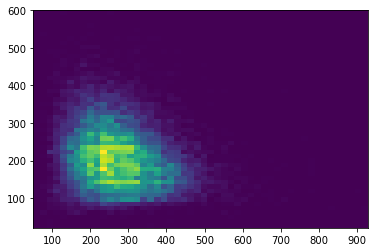

In [14]:
from matplotlib import pyplot as plt

plt.hist2d(shapes[:, 1], shapes[:, 0], bins=50)